In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from functions import (Calculate_CFD, plot_gaussian, get_gaussian_params,
                       calculate_gaussian_center, calculate_slope_y_intercept)

In [47]:
# Load data 
dir = 'Pulsos15CM20250130_version2/'
data0 = np.load(os.path.join(dir, 'Na22_norm_pos0_test.npz'))['data']
data1 = np.load(os.path.join(dir, 'Na22_norm_pos1_test.npz'))['data']
data2 = np.load(os.path.join(dir, 'Na22_norm_pos2_test.npz'))['data']
data3 = np.load(os.path.join(dir, 'Na22_norm_pos3_test.npz'))['data']
data4 = np.load(os.path.join(dir, 'Na22_norm_pos4_test.npz'))['data']
data5 = np.load(os.path.join(dir, 'Na22_norm_pos5_test.npz'))['data']

data_min_1 = np.load(os.path.join(dir, 'Na22_norm_pos_min_1_test.npz'))['data']
data_min_2 = np.load(os.path.join(dir, 'Na22_norm_pos_min_2_test.npz'))['data']
data_min_3 = np.load(os.path.join(dir, 'Na22_norm_pos_min_3_test.npz'))['data']
data_min_4 = np.load(os.path.join(dir, 'Na22_norm_pos_min_4_test.npz'))['data']
data_min_5 = np.load(os.path.join(dir, 'Na22_norm_pos_min_5_test.npz'))['data']

test_data = np.concatenate((data0, data1, data2, 
                            data3, data4, data5,
                            data_min_1, data_min_2, 
                            data_min_3, data_min_4, data_min_5), axis = 0)

print('Número de casos de test: ', test_data.shape[0])

Número de casos de test:  330000


In [71]:
fraction =  0.2 #0.064    # Fraction to attenuate pulse for CFD
shift = 1.5 #6.8         # Delay for CFD 
threshold = 0.04    # Threshold for relative Leading Edge
nbins = 21
time_step = 0.2     # In ns
positions = 0.066*np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])  # Expected time difference of each position

(5.348451214308709, -0.0002334581731969238, 0.2212666203151608)


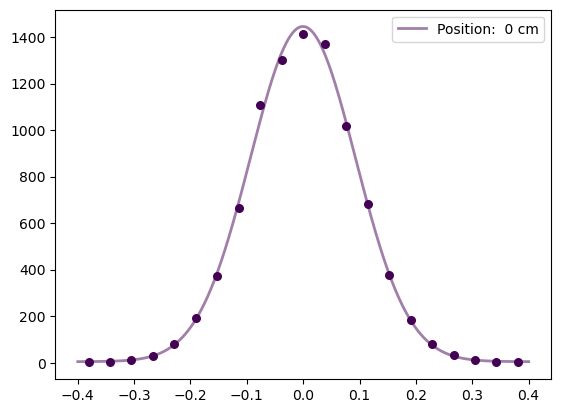

In [72]:
dir = '/home/josea/PracticaTimingDigital'
test_data2 = np.load(os.path.join(dir, 'pulsoNa22:filt_norm.npz'))['data']

timestamps_CFD_dec0_DATA0 = Calculate_CFD(test_data2[10000:, :150, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA0 = Calculate_CFD(test_data2[10000:, :150, 1], fraction = fraction, shift = shift, time_step = time_step)

TOF_CFD_0 = timestamps_CFD_dec0_DATA0 - timestamps_CFD_dec1_DATA0
centroid_V00 = calculate_gaussian_center(TOF_CFD_0[None,:], nbins = 41, limit = 3) 
plot_gaussian(TOF_CFD_0, centroid_V00, range = 0.4, label = 'Position:  0 cm', nbins = nbins, color = colors[0])
params_0, errors_0 = get_gaussian_params(TOF_CFD_0, centroid_V00, range = 0.6, nbins = nbins)
print(params_0)

# **CFD**

In [73]:
timestamps_CFD_dec0_DATA0 = Calculate_CFD(data0[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA0 = Calculate_CFD(data0[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA1 = Calculate_CFD(data1[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA1 = Calculate_CFD(data1[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA2 = Calculate_CFD(data2[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA2 = Calculate_CFD(data2[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA3 = Calculate_CFD(data3[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA3 = Calculate_CFD(data3[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA4 = Calculate_CFD(data4[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA4 = Calculate_CFD(data4[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA5 = Calculate_CFD(data5[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA5 = Calculate_CFD(data5[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_min_1 = Calculate_CFD(data_min_1[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_min_1 = Calculate_CFD(data_min_1[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_min_2 = Calculate_CFD(data_min_2[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_min_2 = Calculate_CFD(data_min_2[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_min_3 = Calculate_CFD(data_min_3[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_min_3 = Calculate_CFD(data_min_3[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_min_4 = Calculate_CFD(data_min_4[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_min_4 = Calculate_CFD(data_min_4[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_min_5 = Calculate_CFD(data_min_5[:, :500, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_min_5 = Calculate_CFD(data_min_5[:, :500, 1], fraction = fraction, shift = shift, time_step = time_step)


TOF_CFD_0 = timestamps_CFD_dec0_DATA0 - timestamps_CFD_dec1_DATA0
TOF_CFD_1 = timestamps_CFD_dec0_DATA1 - timestamps_CFD_dec1_DATA1
TOF_CFD_2 = timestamps_CFD_dec0_DATA2 - timestamps_CFD_dec1_DATA2
TOF_CFD_3 = timestamps_CFD_dec0_DATA3 - timestamps_CFD_dec1_DATA3
TOF_CFD_4 = timestamps_CFD_dec0_DATA4 - timestamps_CFD_dec1_DATA4
TOF_CFD_5 = timestamps_CFD_dec0_DATA5 - timestamps_CFD_dec1_DATA5

TOF_CFD_min_1 = timestamps_CFD_dec0_DATA_min_1 - timestamps_CFD_dec1_DATA_min_1
TOF_CFD_min_2 = timestamps_CFD_dec0_DATA_min_2 - timestamps_CFD_dec1_DATA_min_2
TOF_CFD_min_3 = timestamps_CFD_dec0_DATA_min_3 - timestamps_CFD_dec1_DATA_min_3
TOF_CFD_min_4 = timestamps_CFD_dec0_DATA_min_4 - timestamps_CFD_dec1_DATA_min_4
TOF_CFD_min_5 = timestamps_CFD_dec0_DATA_min_5 - timestamps_CFD_dec1_DATA_min_5

In [8]:
from scipy.optimize import curve_fit
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def calculate_gaussian_center(vector, nbins = 51, limit = 1):
    """
    Calculate Gaussian fit centroid for each row of the input vector.

    Parameters:
    vector (numpy.ndarray): A 2D array where each row represents a set of data points to be analyzed.
    nbins (int, optional): Number of bins to use for the histogram.
    limits (float, optional): Range of the histogram. 

    Returns:
    numpy.ndarray: Array of centroid values (x0) for each row of the input vector. 
    """
    
    centroid = [] 

    for i in range(vector.shape[0]):
        # Calculate the histogram of the current row of data
        histogN, binsN = np.histogram(vector[i, :], bins = nbins, range = [-limit,limit]) 
        
        # Calculate the bin centers
        cbinsN = 0.5 * (binsN[1:] + binsN[:-1]) 
        
        try:
            # Perform Gaussian fitting
            HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)
            
            # Handle cases where sigmaN is NaN
            if np.isnan(sigmaN):
                sigmaN = 10
                x0N = 10
        except:
            # Handle exceptions by setting default values
            x0N, sigmaN = 10, 10
            
        centroid.append(x0N)
    
    centroid = np.array(centroid, dtype='float64')

    return centroid

In [9]:
def plot_gaussian(array, shift, nbins = 51, label = ' ', range = 0.8, limit = 1, color = ''):
    """
    Plot histogram centered around its peak and overlay Gaussian fit.
    """

    # Compute the initial histogram to find the peak
    histog, bins = np.histogram(array - shift, bins = nbins, range = [-limit,limit])
    cbins = 0.5 * (bins[1:] + bins[:-1])

    # Find peak position
    peak_index = np.argmax(histog)
    peak_value = cbins[peak_index]
    
    # Define a histogram range centered at the peak
    new_min, new_max = peak_value - range, peak_value + range

    # Compute the histogram with the new centered range
    histog, bins = np.histogram(array - shift, bins=nbins, range=(new_min, new_max))
    cbins = 0.5 * (bins[1:] + bins[:-1])
    
    # Scatter plot the points
    plt.scatter(cbins, histog, zorder = 3, s = 30, color = color)
    
    # Fit a Gaussian to the histogram data
    popt = gauss_fit(cbins, histog)
    
    # Generate Gaussian fit curve
    x_fit = np.linspace(new_min, new_max, 500)
    y_fit = gauss(x_fit, *popt)
    
    plt.plot(x_fit, y_fit, linewidth = 2, alpha = 0.5, color = color, label = label)
    plt.legend()

In [10]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
# Generate a list of gradient colors from a modified colormap
num_colors = 11  # Adjust the number of gradient steps

# Get the original magma colormap
original_colormap = cm.get_cmap('viridis')

# Define a range to clip out yellow (top ~10% of the colormap)
clipped_colormap = mcolors.LinearSegmentedColormap.from_list(
    "magma_no_yellow",
    original_colormap(np.linspace(0, 0.85, 256))  # Exclude the top 15% (bright yellow)
)

# Generate colors from the modified colormap
colors = [clipped_colormap(i / (num_colors - 1)) for i in range(num_colors)]


/tmp/ipykernel_297249/2528680332.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_colormap = cm.get_cmap('viridis')


<Figure size 1920x1440 with 0 Axes>

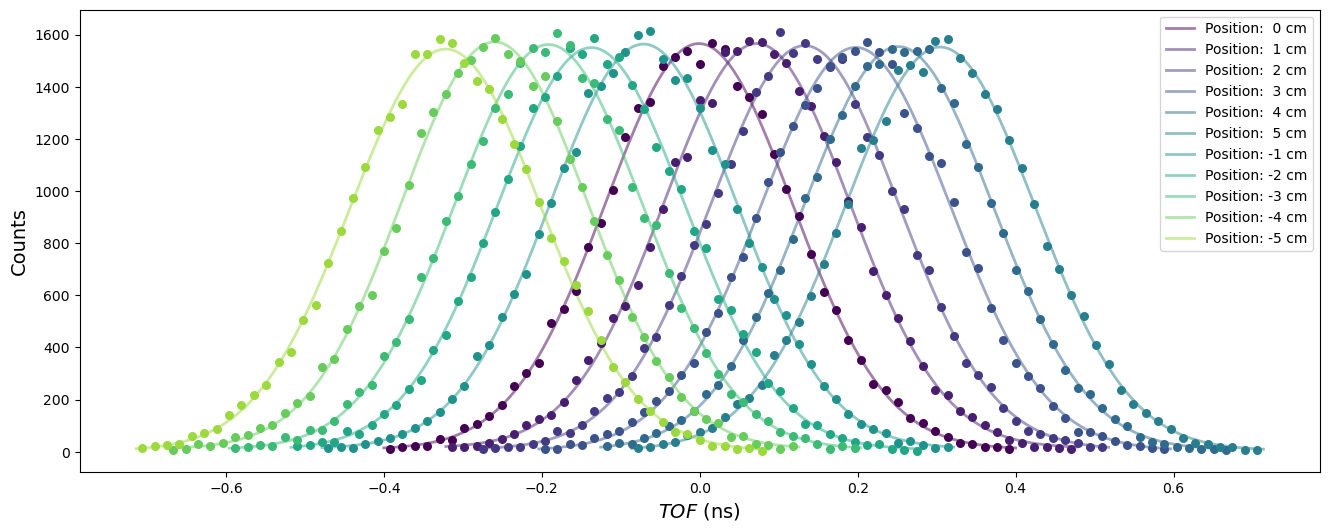

In [74]:
centroid_V00 = calculate_gaussian_center(TOF_CFD_0[None,:], nbins = nbins, limit = 3) 

plt.figure(dpi = 300)
plt.figure(figsize = (16,6))
# Histogram and gaussian fit (Not all positions plotted) 
nbins = 51
plot_gaussian(TOF_CFD_0, centroid_V00, range = 0.4, label = 'Position:  0 cm', nbins = nbins, color = colors[0])
plot_gaussian(TOF_CFD_1, centroid_V00, range = 0.4, label = 'Position:  1 cm', nbins = nbins, color = colors[1])
plot_gaussian(TOF_CFD_2, centroid_V00, range = 0.4, label = 'Position:  2 cm', nbins = nbins, color = colors[2])
plot_gaussian(TOF_CFD_3, centroid_V00, range = 0.4, label = 'Position:  3 cm', nbins = nbins, color = colors[3])
plot_gaussian(TOF_CFD_4, centroid_V00, range = 0.4, label = 'Position:  4 cm', nbins = nbins, color = colors[4])
plot_gaussian(TOF_CFD_5, centroid_V00, range = 0.4, label = 'Position:  5 cm', nbins = nbins, color = colors[5])
plot_gaussian(TOF_CFD_min_1, centroid_V00, range = 0.4, label = 'Position: -1 cm', nbins = nbins, color = colors[6])
plot_gaussian(TOF_CFD_min_2, centroid_V00, range = 0.4, label = 'Position: -2 cm', nbins = nbins, color = colors[7])
plot_gaussian(TOF_CFD_min_3, centroid_V00, range = 0.4, label = 'Position: -3 cm', nbins = nbins, color = colors[8])
plot_gaussian(TOF_CFD_min_4, centroid_V00, range = 0.4, label = 'Position: -4 cm', nbins = nbins, color = colors[9])
plot_gaussian(TOF_CFD_min_5, centroid_V00, range = 0.4, label = 'Position: -5 cm', nbins = nbins, color = colors[10])
plt.xlabel('$TOF$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.savefig('figures/histograms.png')

In [75]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
size = 1000

for i in range(10):
    centroid_V00 = calculate_gaussian_center(TOF_CFD_0[None, i*size : (i+1)*size], nbins = nbins) 
    params_0, errors_0 = get_gaussian_params(TOF_CFD_0[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_1, errors_1 = get_gaussian_params(TOF_CFD_1[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_2, errors_2 = get_gaussian_params(TOF_CFD_2[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_3, errors_3 = get_gaussian_params(TOF_CFD_3[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_4, errors_4 = get_gaussian_params(TOF_CFD_4[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_5, errors_5 = get_gaussian_params(TOF_CFD_5[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)

    params_min_1, errors_min_1 = get_gaussian_params(TOF_CFD_min_1[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_2, errors_min_2 = get_gaussian_params(TOF_CFD_min_2[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_3, errors_min_3 = get_gaussian_params(TOF_CFD_min_3[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_4, errors_min_4 = get_gaussian_params(TOF_CFD_min_4[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_5, errors_min_5 = get_gaussian_params(TOF_CFD_min_5[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    
    resolution = np.mean([params_min_5[2], params_min_4[2],
                          params_min_3[2], params_min_2[2], 
                          params_min_1[2], params_0[2],  
                          params_1[2], params_2[2], params_3[2], 
                          params_4[2], params_5[2],  
                          ])
    
    resolution_list.append(resolution)
    
    centroids = np.array([params_min_5[1], params_min_4[1],
                          params_min_3[1], params_min_2[1], 
                          params_min_1[1], params_0[1],  
                          params_1[1],  params_2[1], params_3[1], 
                          params_4[1],  params_5[1]])
    
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_min_5 = abs((TOF_CFD_min_5 - centroid_V00[:, np.newaxis] - positions[0]))
    error_min_4 = abs((TOF_CFD_min_4 - centroid_V00[:, np.newaxis] - positions[1]))
    error_min_3 = abs((TOF_CFD_min_3 - centroid_V00[:, np.newaxis] - positions[2]))
    error_min_2 = abs((TOF_CFD_min_2 - centroid_V00[:, np.newaxis] - positions[3]))
    error_min_1 = abs((TOF_CFD_min_1 - centroid_V00[:, np.newaxis] - positions[4]))
    error_0 = abs((TOF_CFD_0 - centroid_V00[:, np.newaxis] - positions[5]))
    error_1 = abs((TOF_CFD_1 - centroid_V00[:, np.newaxis] - positions[6]))
    error_2 = abs((TOF_CFD_2 - centroid_V00[:, np.newaxis] - positions[7]))
    error_3 = abs((TOF_CFD_3 - centroid_V00[:, np.newaxis] - positions[8]))
    error_4 = abs((TOF_CFD_4 - centroid_V00[:, np.newaxis] - positions[9]))
    error_5 = abs((TOF_CFD_5 - centroid_V00[:, np.newaxis] - positions[10]))
    
  
    Error = np.concatenate((error_0, 
                            error_1, error_2, error_3,
                            error_4, error_5, 
                            error_min_1, error_min_2, error_min_3,
                            error_min_4, error_min_5), axis = 1)   

    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)


Mean CTR:  280.53663819002685
Std CTR:  2.1876334707204035
Mean bias:  7.923133238360313
Std bias:  1.3159737959818956
Mean MAE:  119.72501804724477
Std MAE:  0.07845545978152582


# **RELATIVE LEADING EDGE** 

In [25]:
timestamps_RLED_dec0_DATA0_list = []
timestamps_RLED_dec0_DATA1_list = []
timestamps_RLED_dec0_DATA2_list = []
timestamps_RLED_dec0_DATA3_list = []
timestamps_RLED_dec0_DATA4_list = []
timestamps_RLED_dec0_DATA5_list = []

timestamps_RLED_dec0_DATA_min_1_list = []
timestamps_RLED_dec0_DATA_min_2_list = []
timestamps_RLED_dec0_DATA_min_3_list = []
timestamps_RLED_dec0_DATA_min_4_list = []
timestamps_RLED_dec0_DATA_min_5_list = []

timestamps_RLED_dec1_DATA0_list = []
timestamps_RLED_dec1_DATA1_list = []
timestamps_RLED_dec1_DATA2_list = []
timestamps_RLED_dec1_DATA3_list = []
timestamps_RLED_dec1_DATA4_list = []
timestamps_RLED_dec1_DATA5_list = []

timestamps_RLED_dec1_DATA_min_1_list = []
timestamps_RLED_dec1_DATA_min_2_list = []
timestamps_RLED_dec1_DATA_min_3_list = []
timestamps_RLED_dec1_DATA_min_4_list = []
timestamps_RLED_dec1_DATA_min_5_list = []


for i in range(data0.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data0[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data0[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA0_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA0_list.append(timestamp_dec1)

for i in range(data1.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data1[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data1[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA1_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA1_list.append(timestamp_dec1)

for i in range(data2.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data2[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data2[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA2_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA2_list.append(timestamp_dec1)

for i in range(data3.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data3[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data3[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA3_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA3_list.append(timestamp_dec1)

for i in range(data4.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data4[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data4[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA4_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA4_list.append(timestamp_dec1)

for i in range(data4.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data5[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data5[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA5_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA5_list.append(timestamp_dec1)

for i in range(data0.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_min_1[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_min_1[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_min_1_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_min_1_list.append(timestamp_dec1)

for i in range(data0.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_min_2[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_min_2[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_min_2_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_min_2_list.append(timestamp_dec1)

for i in range(data0.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_min_3[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_min_3[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_min_3_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_min_3_list.append(timestamp_dec1)

for i in range(data0.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_min_4[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_min_4[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_min_4_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_min_4_list.append(timestamp_dec1)

for i in range(data0.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_min_5[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_min_5[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_DATA_min_5_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_min_5_list.append(timestamp_dec1)


timestamps_RLED_dec0_DATA0 = np.array(timestamps_RLED_dec0_DATA0_list)
timestamps_RLED_dec0_DATA1 = np.array(timestamps_RLED_dec0_DATA1_list)
timestamps_RLED_dec0_DATA2 = np.array(timestamps_RLED_dec0_DATA2_list)
timestamps_RLED_dec0_DATA3 = np.array(timestamps_RLED_dec0_DATA3_list)
timestamps_RLED_dec0_DATA4 = np.array(timestamps_RLED_dec0_DATA4_list)
timestamps_RLED_dec0_DATA5 = np.array(timestamps_RLED_dec0_DATA5_list)

timestamps_RLED_dec0_DATA_min_1 = np.array(timestamps_RLED_dec0_DATA_min_1_list)
timestamps_RLED_dec0_DATA_min_2 = np.array(timestamps_RLED_dec0_DATA_min_2_list)
timestamps_RLED_dec0_DATA_min_3 = np.array(timestamps_RLED_dec0_DATA_min_3_list)
timestamps_RLED_dec0_DATA_min_4 = np.array(timestamps_RLED_dec0_DATA_min_4_list)
timestamps_RLED_dec0_DATA_min_5 = np.array(timestamps_RLED_dec0_DATA_min_5_list)

timestamps_RLED_dec1_DATA0 = np.array(timestamps_RLED_dec1_DATA0_list)
timestamps_RLED_dec1_DATA1 = np.array(timestamps_RLED_dec1_DATA1_list)
timestamps_RLED_dec1_DATA2 = np.array(timestamps_RLED_dec1_DATA2_list)
timestamps_RLED_dec1_DATA3 = np.array(timestamps_RLED_dec1_DATA3_list)
timestamps_RLED_dec1_DATA4 = np.array(timestamps_RLED_dec1_DATA4_list)
timestamps_RLED_dec1_DATA5 = np.array(timestamps_RLED_dec1_DATA5_list)

timestamps_RLED_dec1_DATA_min_1 = np.array(timestamps_RLED_dec1_DATA_min_1_list)
timestamps_RLED_dec1_DATA_min_2 = np.array(timestamps_RLED_dec1_DATA_min_2_list)
timestamps_RLED_dec1_DATA_min_3 = np.array(timestamps_RLED_dec1_DATA_min_3_list)
timestamps_RLED_dec1_DATA_min_4 = np.array(timestamps_RLED_dec1_DATA_min_4_list)
timestamps_RLED_dec1_DATA_min_5 = np.array(timestamps_RLED_dec1_DATA_min_5_list)


In [28]:
TOF_RLED_0 = timestamps_RLED_dec0_DATA0 - timestamps_RLED_dec1_DATA0
TOF_RLED_1 = timestamps_RLED_dec0_DATA1 - timestamps_RLED_dec1_DATA1
TOF_RLED_2 = timestamps_RLED_dec0_DATA2 - timestamps_RLED_dec1_DATA2
TOF_RLED_3 = timestamps_RLED_dec0_DATA3 - timestamps_RLED_dec1_DATA3
TOF_RLED_4 = timestamps_RLED_dec0_DATA4 - timestamps_RLED_dec1_DATA4
TOF_RLED_5 = timestamps_RLED_dec0_DATA5 - timestamps_RLED_dec1_DATA5

TOF_RLED_min_1 = timestamps_RLED_dec0_DATA_min_1 - timestamps_RLED_dec1_DATA_min_1
TOF_RLED_min_2 = timestamps_RLED_dec0_DATA_min_2 - timestamps_RLED_dec1_DATA_min_2
TOF_RLED_min_3 = timestamps_RLED_dec0_DATA_min_3 - timestamps_RLED_dec1_DATA_min_3
TOF_RLED_min_4 = timestamps_RLED_dec0_DATA_min_4 - timestamps_RLED_dec1_DATA_min_4
TOF_RLED_min_5 = timestamps_RLED_dec0_DATA_min_5 - timestamps_RLED_dec1_DATA_min_5

min 5: CENTROID(ns) = -0.3160 +/- 6.10976  FWHM(ns) = 0.2521 +/- 0.00090
min 4: CENTROID(ns) = -0.2537 +/- 6.30145  FWHM(ns) = 0.2477 +/- 0.00088
min 3: CENTROID(ns) = -0.1858 +/- 5.28798  FWHM(ns) = 0.2452 +/- 0.00071
min 2: CENTROID(ns) = -0.1168 +/- 5.04283  FWHM(ns) = 0.2512 +/- 0.00070
min 1: CENTROID(ns) = -0.0679 +/- 6.47686  FWHM(ns) = 0.2537 +/- 0.00091
0: CENTROID(ns) = 0.0026 +/- 4.95305  FWHM(ns) = 0.2480 +/- 0.00076
1: CENTROID(ns) = 0.0828 +/- 7.50154  FWHM(ns) = 0.2467 +/- 0.00108
2: CENTROID(ns) = 0.1415 +/- 5.40365  FWHM(ns) = 0.2509 +/- 0.00083
3: CENTROID(ns) = 0.2051 +/- 4.83650  FWHM(ns) = 0.2516 +/- 0.00075
4: CENTROID(ns) = 0.2591 +/- 5.07376  FWHM(ns) = 0.2547 +/- 0.00084
5: CENTROID(ns) = 0.2963 +/- 4.96524  FWHM(ns) = 0.2501 +/- 0.00085


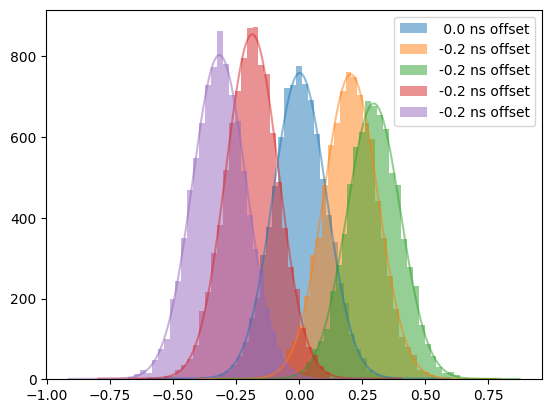

In [29]:
centroid_V00 = calculate_gaussian_center(TOF_CFD_0[None,:], nbins = nbins, limit = 3) 

# Histogram and gaussian fit (Not all positions plotted) 
plot_gaussian(TOF_RLED_0, centroid_V00, range = 0.6, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_3, centroid_V00, range = 0.6, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_5, centroid_V00, range = 0.6, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_min_3, centroid_V00, range = 0.6, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_min_5, centroid_V00, range = 0.6, label = '-0.2 ns offset', nbins = nbins)

params_0, errors_0 = get_gaussian_params(TOF_RLED_0, centroid_V00, range = 0.6, nbins = nbins)
params_1, errors_1 = get_gaussian_params(TOF_RLED_1, centroid_V00, range = 0.6, nbins = nbins)
params_2, errors_2 = get_gaussian_params(TOF_RLED_2, centroid_V00, range = 0.6, nbins = nbins)
params_3, errors_3 = get_gaussian_params(TOF_RLED_3, centroid_V00, range = 0.6, nbins = nbins)
params_4, errors_4 = get_gaussian_params(TOF_RLED_4, centroid_V00, range = 0.6, nbins = nbins)
params_5, errors_5 = get_gaussian_params(TOF_RLED_5, centroid_V00, range = 0.6, nbins = nbins)

params_min_1, errors_min_1 = get_gaussian_params(TOF_RLED_min_1, centroid_V00, range = 0.6, nbins = nbins)
params_min_2, errors_min_2 = get_gaussian_params(TOF_RLED_min_2, centroid_V00, range = 0.6, nbins = nbins)
params_min_3, errors_min_3 = get_gaussian_params(TOF_RLED_min_3, centroid_V00, range = 0.6, nbins = nbins)
params_min_4, errors_min_4 = get_gaussian_params(TOF_RLED_min_4, centroid_V00, range = 0.6, nbins = nbins)
params_min_5, errors_min_5 = get_gaussian_params(TOF_RLED_min_5, centroid_V00, range = 0.6, nbins = nbins)

print("min 5: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_min_5[1], errors_min_5[1], params_min_5[2], errors_min_5[2]))
print("min 4: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_min_4[1], errors_min_4[1], params_min_4[2], errors_min_4[2]))
print("min 3: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_min_3[1], errors_min_3[1], params_min_3[2], errors_min_3[2]))
print("min 2: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_min_2[1], errors_min_2[1], params_min_2[2], errors_min_2[2]))
print("min 1: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_min_1[1], errors_min_1[1], params_min_1[2], errors_min_1[2]))
print("0: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_0[1], errors_0[1], params_0[2], errors_0[2]))
print("1: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_1[1], errors_1[1], params_1[2], errors_1[2]))
print("2: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_2[1], errors_2[1], params_2[2], errors_2[2]))
print("3: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_3[1], errors_3[1], params_3[2], errors_3[2]))
print("4: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_4[1], errors_4[1], params_4[2], errors_4[2]))
print("5: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_5[1], errors_5[1], params_5[2], errors_5[2]))

In [30]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
size = 1000

for i in range(10):
    centroid_V00 = calculate_gaussian_center(TOF_RLED_0[None, i*size : (i+1)*size], nbins = nbins) 
    params_0, errors_0 = get_gaussian_params(TOF_RLED_0[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_1, errors_1 = get_gaussian_params(TOF_RLED_1[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_2, errors_2 = get_gaussian_params(TOF_RLED_2[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_3, errors_3 = get_gaussian_params(TOF_RLED_3[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_4, errors_4 = get_gaussian_params(TOF_RLED_4[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_5, errors_5 = get_gaussian_params(TOF_RLED_5[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)

    params_min_1, errors_min_1 = get_gaussian_params(TOF_RLED_min_1[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_2, errors_min_2 = get_gaussian_params(TOF_RLED_min_2[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_3, errors_min_3 = get_gaussian_params(TOF_RLED_min_3[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_4, errors_min_4 = get_gaussian_params(TOF_RLED_min_4[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    params_min_5, errors_min_5 = get_gaussian_params(TOF_RLED_min_5[i*size : (i+1)*size], centroid_V00, range = 0.6, nbins = nbins)
    
    resolution = np.mean([params_min_5[2], params_min_4[2],
                          params_min_3[2], params_min_2[2], 
                          params_min_1[2], params_0[2],  
                          params_1[2], params_2[2], params_3[2], 
                          params_4[2], params_5[2],  
                          ])
    
    resolution_list.append(resolution)
    
    centroids = np.array([params_min_5[1], params_min_4[1],
                          params_min_3[1], params_min_2[1], 
                          params_min_1[1], params_0[1],  
                          params_1[1],  params_2[1], params_3[1], 
                          params_4[1],  params_5[1]])
    
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_min_5 = abs((TOF_RLED_min_5 - centroid_V00[:, np.newaxis] - positions[0]))
    error_min_4 = abs((TOF_RLED_min_4 - centroid_V00[:, np.newaxis] - positions[1]))
    error_min_3 = abs((TOF_RLED_min_3 - centroid_V00[:, np.newaxis] - positions[2]))
    error_min_2 = abs((TOF_RLED_min_2 - centroid_V00[:, np.newaxis] - positions[3]))
    error_min_1 = abs((TOF_RLED_min_1 - centroid_V00[:, np.newaxis] - positions[4]))
    error_0 = abs((TOF_RLED_0 - centroid_V00[:, np.newaxis] - positions[5]))
    error_1 = abs((TOF_RLED_1 - centroid_V00[:, np.newaxis] - positions[6]))
    error_2 = abs((TOF_RLED_2 - centroid_V00[:, np.newaxis] - positions[7]))
    error_3 = abs((TOF_RLED_3 - centroid_V00[:, np.newaxis] - positions[8]))
    error_4 = abs((TOF_RLED_4 - centroid_V00[:, np.newaxis] - positions[9]))
    error_5 = abs((TOF_RLED_5 - centroid_V00[:, np.newaxis] - positions[10]))
    
  
    Error = np.concatenate((error_0, 
                            error_1, error_2, error_3,
                            error_4, error_5, 
                            error_min_1, error_min_2, error_min_3,
                            error_min_4, error_min_5), axis = 1)   

    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)


Mean CTR:  250.34299092784235
Std CTR:  3.534557669027197
Mean bias:  10.630955705119508
Std bias:  1.261304047938182
Mean MAE:  3754.3359575101044
Std MAE:  0.3884197832847147
